## Tutorial on the pullback operation with collision avoidance spec

---

In [1]:
import casadi as ca
import numpy as np
from fabrics.diffGeometry.spec import Spec

#### 1. Simple collision avoidance spec

We will create a simple spec that describes collision avoidance behavior.\
$\mathbf{x}$ here is the distance to the obstacle, and the spec is defined on the task space $\mathcal{X}$.

Spec $(\mathbf{M}, \mathbf{f})_\mathcal{X}$:

\begin{align}
\mathbf{M}\ddot{\mathbf{x}} + \mathbf{f} = \mathbf{0} \\
with: \\
\mathbf{M} &= \begin{pmatrix} 1 \end{pmatrix} \\
\mathbf{f} &= \begin{pmatrix} \frac{-3}{\mathbf{x}} || \dot{\mathbf{x}} ||^2_2 \end{pmatrix} \\
\end{align}


In [2]:
x_o = ca.SX.sym('x_o', 1)
xdot_o = ca.SX.sym('xdot_o', 1)
M = ca.SX([[1.0]])
#f = ca.vcat([-3.0/x_o[0] * ca.norm_2(xdot_o)**2])
f = ca.vcat([-3.0/x_o[0] * xdot_o**2])
simple_spec = Spec(M, f=f, x=x_o, xdot=xdot_o)
simple_spec.concretize()

#### 2. Obstacle

Let us first define an sphere obstacle with the following position and radius:

\begin{align}
\mathbf{q}_{obs} &= \begin{pmatrix} 1 \\ 0 \end{pmatrix} \\
r_{obs} &= 0.5
\end{align}


In [3]:
from mpscenes.obstacles.sphere_obstacle import SphereObstacle
circle_dict = {
    'type': 'SphereObstacle',
    'geometry': {
        'position': [1.0, 0.0],
        'radius': 0.5,
    }
}
obstacle = SphereObstacle(name="CircleObstacle", content_dict = circle_dict)

#### 3. Differential map

Now we need to create a differential map $\phi: \mathcal{Q} \rightarrow \mathcal{X}$ between distance task space $\mathcal{X}$ and robot configuration space $\mathcal{Q}$.

\begin{align}
\phi(\mathbf{q}) = \frac{||\mathbf{q} - \mathbf{q}_{obs}||_2}{r_{obs}} - 1
\end{align}


In [4]:
from fabrics.diffGeometry.diffMap import DifferentialMap
from fabrics.helpers.variables import Variables
x = ca.SX.sym('x', 2)
xdot = ca.SX.sym('xdot', 2)
variables = Variables(state_variables={'x': x, 'xdot': xdot})
phi = ca.norm_2(x - obstacle.position())/obstacle.radius() - 1
diff_map = DifferentialMap(phi, variables)

#### 4. Pullback operation

Using the differential map $\phi$, the spec can be pulled to the configuration space as $(\mathbf{M}, \mathbf{f})_\mathcal{Q}$ from the task space as $(\mathbf{M}, \mathbf{f})_\mathcal{X}$ using the pullback operation:

\begin{align}
(\mathbf{M}, \mathbf{f})_\mathcal{Q} = pull_{\phi} (\mathbf{M}, \mathbf{f})_\mathcal{X} = \left(\mathbf{J}^T\mathbf{M}\mathbf{J}, \mathbf{J}^T(\mathbf{f} + \mathbf{M}\mathbf{\dot{J}}\mathbf{\dot{q}})\right)
\end{align}

The pullback operation is derived using the differential map's Jacobian $\mathbf{J} = \partial_{\mathbf{q}}\phi $ and $\ddot{\mathbf{x}} = \mathbf{J}\mathbf{\ddot{q}} + \mathbf{\dot{J}}\mathbf{\dot{q}}$ as follows:
\begin{align}
pull_{\phi} (\mathbf{M}, \mathbf{f})_\mathcal{X} = \mathbf{J}^T(\mathbf{M}\ddot{\mathbf{x}} + \mathbf{f}) &= \mathbf{J}^T\left(\mathbf{M}(\mathbf{J}\mathbf{\ddot{q}} + \mathbf{\dot{J}}\mathbf{\dot{q}}) + \mathbf{f}\right) \\
&= (\mathbf{J}^T\mathbf{M}\mathbf{J})\mathbf{\ddot{q}} + \mathbf{J}^T(\mathbf{f} + \mathbf{M}\mathbf{\dot{J}}\mathbf{\dot{q}})
\end{align}

In the next cell, the simple collision avoidance spec is pulled back to the configuration space and rewriten in the motion policy form with concretize.

In [5]:
pulled_spec = simple_spec.pull(diff_map)

M_pulled = pulled_spec.M()
f_pulled = pulled_spec.f()

#### 5. Summation

In [6]:
M_1_obstacle = M_pulled
f_1_obstacle = f_pulled

combined_pulled_spec_1 = Spec(M_1_obstacle, f=f_1_obstacle, x=x, xdot=xdot)
combined_pulled_spec_1.concretize()

M_10_obstacle = M_pulled + M_pulled + M_pulled + M_pulled + M_pulled + M_pulled + M_pulled + M_pulled + M_pulled + M_pulled
f_10_obstacle = f_pulled + f_pulled + f_pulled + f_pulled + f_pulled + f_pulled + f_pulled + f_pulled + f_pulled + f_pulled

combined_pulled_spec_10 = Spec(M_10_obstacle, f=f_10_obstacle, x=x, xdot=xdot)
combined_pulled_spec_10.concretize()

### Planar simulation of simple collision avoidance spec

Test the spec inside a planar simulation environment.\
The spec produces a trajectory which will be visualized by the environment.

In [7]:
import gym
import numpy as np
import planarenvs.point_robot
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

#### 1. Run the simulation to create the first trajectory

In [8]:
# Baseline + 1 obstacle spec
env = gym.make("point-robot-acc-v0", render=False, dt=0.01)
init_pos = np.array([-1.0, 0.1])
init_vel = np.array([1.4, 0.0])
ob = env.reset(pos=init_pos, vel=init_vel)
env.add_obstacle(obstacle)
n_steps = 1000
positions_1 = np.zeros((n_steps, 2))
actions_1 = np.zeros((n_steps, 2))
for i in range(n_steps):
    x = ob['joint_state']['position']
    positions_1[i] = x
    xdot = ob['joint_state']['velocity']
    M, h, action = combined_pulled_spec_1.evaluate(x=x, xdot=xdot)
    actions_1[i] = action
    ob, _, _, _ = env.step(action)
env.close()

#### 2. Run the simulation to create the second trajectory

In [9]:
# Baseline + 10 obstacles spec
env = gym.make("point-robot-acc-v0", render=False, dt=0.01)
init_pos = np.array([-1.0, 0.1])
init_vel = np.array([1.4, 0.0])
ob = env.reset(pos=init_pos, vel=init_vel)
env.add_obstacle(obstacle)
n_steps = 1000
positions_10 = np.zeros((n_steps, 2))
actions_10 = np.zeros((n_steps, 2))
for i in range(n_steps):
    x = ob['joint_state']['position']
    positions_10[i] = x
    xdot = ob['joint_state']['velocity']
    M, h, action = combined_pulled_spec_10.evaluate(x=x, xdot=xdot)
    actions_10[i] = action
    ob, _, _, _ = env.step(action)
env.close()

#### 2. Visualize the trajectories

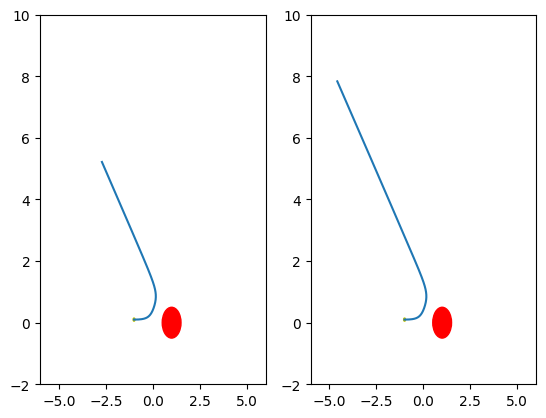

In [10]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2)
for m, subplot in np.ndenumerate(axs):
    subplot.set_xlim(-6, 6)
    subplot.set_ylim(-2, 10)

# Baseline + 1 obstacle spec
axs[0].plot(positions_1[:,0], positions_1[:,1])
initial_location = plt.Circle((positions_1[:,0][0], positions_1[:,1][0]), radius=0.05, color='y')
obst1 = plt.Circle(obstacle.position(), radius=obstacle.radius(), color='r')
axs[0].add_patch(initial_location)
axs[0].add_patch(obst1)

# Baseline + 10 obstacles spec
axs[1].plot(positions_10[:,0], positions_10[:,1])
initial_location = plt.Circle((positions_10[:,0][0], positions_10[:,1][0]), radius=0.05, color='y')
obst1 = plt.Circle(obstacle.position(), radius=obstacle.radius(), color='r')
axs[1].add_patch(initial_location)
axs[1].add_patch(obst1)
plt.show()

x_1_obs_last = np.array((positions_1[:,0][-1], positions_1[:,1][-1]))
x_10_obs_last = np.array((positions_10[:,0][-1], positions_10[:,1][-1]))

In [11]:
print(f"Last position 1 obstacle   : {x_1_obs_last}")
print(f"Last position 10 obstacles : {x_10_obs_last}")
print("--------------------------------------------------------")
print(f"Last action 1 obstacle     : {actions_1[-1]}")
print(f"Last action 10 obstacles   : {actions_10[-1]}")
print("--------------------------------------------------------")
print(f"Average action 1 obstacle   : {np.average((actions_1), axis=0)}")
print(f"Average action 10 obstacles : {np.average((actions_10), axis=0)}")
print("--------------------------------------------------------")
print(np.mean(actions_10) / np.mean(actions_1))

Last position 1 obstacle   : [-2.7085475   5.21795428]
Last position 10 obstacles : [-4.58157302  7.83598063]
--------------------------------------------------------
Last action 1 obstacle     : [-965.99175739 1358.79115915]
Last action 10 obstacles   : [-5345.0355835  7573.1328125]
--------------------------------------------------------
Average action 1 obstacle   : [-4.4225636   6.02912916]
Average action 10 obstacles : [-14.89524246  20.84263688]
--------------------------------------------------------
3.7019307378652595
